# Setup

In [1]:
%matplotlib inline

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline

from IPython.display import display, Markdown

from chmp.ds import (
    reload, mpl_set,
    FuncTransformer, FilterLowFrequencyTransfomer, OneHotEncoder, DataFrameEstimator, 
    find_categorical_columns, Loop,
)

from chmp.app.causality.dataset import census
from chmp.app.causality.model import (
    action_p_to_propensity, 
    build_standard_sklearn_classifier,
    evaluate,
    
    BinaryOutcomeRegressionPolicy, 
    DirectClassifierPolicy,
    DoublyRobustClassifierPolicy,
    RegressingBinaryClassifier,
)

ImportError: cannot import name 'Loop'

In [ ]:
_logger = logging.getLogger(__name__)

# Dataset Overview

## Census Data

Generated by classification -> partially labelled transformation.

- Original target `target`
- Action variable `action`
- Outcome for classification `outcome` 
- Outcome for regression `value`

In [5]:
data_census = pd.read_parquet('./data/census.parquet')
for col, typ in census.columns:
    data_census = data_census.assign(**{col: data_census[col].astype(typ)})

data_census['propensity'] = action_p_to_propensity(data_census['action'], data_census['action_p'])

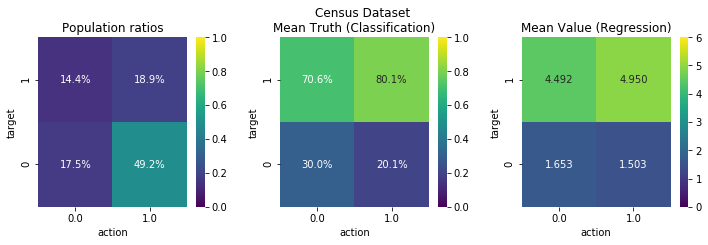

In [6]:
plt.figure(figsize=(12, 3.25))
mpl_set(top=0.85, wspace=0.3, suptitle='Census Dataset')

plt.subplot(1, 3, 1)
sns.heatmap(
    data_census.groupby(['target', 'action']).size().pipe(lambda s: s / s.sum()).unstack(),
    vmin=0, vmax=1, cmap='viridis', annot=True, fmt='.1%',
)
mpl_set(title='Population ratios', invert='y')

plt.subplot(1, 3, 2)
sns.heatmap(
    data_census.groupby(['target', 'action'])['outcome'].mean().unstack(),
    vmin=0, vmax=1, cmap='viridis', annot=True, fmt='.1%',
)
mpl_set(title='Mean Truth (Classification)', invert='y')

plt.subplot(1, 3, 3)
sns.heatmap(
    data_census.groupby(['target', 'action'])['value'].mean().unstack(),
    vmin=0, vmax=6, cmap='viridis', annot=True, fmt='.3f',
)
mpl_set(title='Mean Value (Regression)', invert='y')
pass

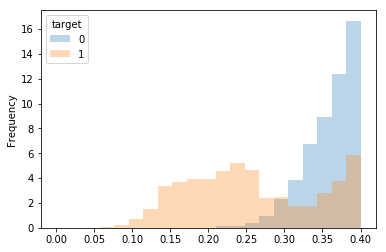

In [7]:
(
    data_census
    .query('target == 0')
    ['action_p']
    .plot.hist(normed=True, alpha=0.3, range=(0, 0.4), bins=21, ax=plt.gca(), label='0')
)
(
    data_census
    .query('target == 1')
    ['action_p']
    .plot.hist(normed=True, alpha=0.3, range=(0, 0.4), bins=21, ax=plt.gca(), label='1')
)
plt.legend(loc='best', title='target')
pass

In [8]:
# prep training ...
data_census_train = data_census.query('train == 1').copy().reset_index(drop=True)
data_census_test = data_census.query('train == 0').copy().reset_index(drop=True)
data_census_train['weight_true'] = (
    (data_census_train['action'] == 0) / (1 - data_census_train['action_p']) +
    (data_census_train['action'] == 1) / data_census_train['action_p']
)

print(f'train size: {len(data_census_train):,d}, test size: {len(data_census_test):,d}')

train size: 199,786, test size: 99,498


# Model Comparison

In [41]:
estimators = [
    ('regression', lambda: BinaryOutcomeRegressionPolicy(
        build_standard_sklearn_classifier(census.features + ['action']),
    )),
    ('direct', lambda: DirectClassifierPolicy(
        build_standard_sklearn_classifier(census.features),
        propensity_column='propensity',
    )),
    ('doubly_robust', lambda: DoublyRobustClassifierPolicy(
        RegressingBinaryClassifier(build_standard_sklearn_classifier(census.features + ['action'])),
        build_standard_sklearn_classifier(census.features),
        propensity_column='propensity',
        action_values=[0, 1],
    )),
]

In [42]:
metrics = []

for outer_loop, _ in Loop.over(range(5)):
    for inner_loop, (label, est) in Loop.over(estimators):
        est = est()
        est.fit(data_census_train)

        metrics.append(evaluate(
            est, data_census_train, 
            value_columns=['outcome_0_p_det', 'outcome_1_p_det'],
            propensity_column='propensity',
            label=f'{label} (train)',
        ))
        metrics.append(evaluate(
            est, data_census_test, 
            value_columns=['outcome_0_p_det', 'outcome_1_p_det'],
            propensity_column='propensity',
            label=f'{label} (test)',
        ))
        print(f'{outer_loop:[fr} {inner_loop}'.ljust(120), end='\r')

INFO:chmp.app.off_policy.model.evaluation:predict regression (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (train)
INFO:chmp.app.off_policy.model.evaluation:predict regression (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (test)


INFO:chmp.app.off_policy.model.evaluation:predict direct (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (train)
INFO:chmp.app.off_policy.model.evaluation:predict direct (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (test)


INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (test)


INFO:chmp.app.off_policy.model.evaluation:predict regression (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (train)
INFO:chmp.app.off_policy.model.evaluation:predict regression (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (test)


INFO:chmp.app.off_policy.model.evaluation:predict direct (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (train)
INFO:chmp.app.off_policy.model.evaluation:predict direct (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (test)


INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (test)


INFO:chmp.app.off_policy.model.evaluation:predict regression (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (train)
INFO:chmp.app.off_policy.model.evaluation:predict regression (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (test)


INFO:chmp.app.off_policy.model.evaluation:predict direct (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (train)
INFO:chmp.app.off_policy.model.evaluation:predict direct (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (test)


INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (test)


INFO:chmp.app.off_policy.model.evaluation:predict regression (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (train)
INFO:chmp.app.off_policy.model.evaluation:predict regression (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (test)


INFO:chmp.app.off_policy.model.evaluation:predict direct (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (train)
INFO:chmp.app.off_policy.model.evaluation:predict direct (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (test)


INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (test)


INFO:chmp.app.off_policy.model.evaluation:predict regression (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (train)
INFO:chmp.app.off_policy.model.evaluation:predict regression (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations regression (test)


INFO:chmp.app.off_policy.model.evaluation:predict direct (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (train)
INFO:chmp.app.off_policy.model.evaluation:predict direct (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations direct (test)


INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (train)
INFO:chmp.app.off_policy.model.evaluation:predict doubly_robust (test)
INFO:chmp.app.off_policy.model.evaluation:run evaluations doubly_robust (test)


In [43]:
pd.DataFrame(metrics).set_index('label').transpose().drop(['value_plot'], axis=0)

label,regression (train),regression (test),direct (train),direct (test),doubly_robust (train),doubly_robust (test),regression (train),regression (test),direct (train),direct (test),...,direct (train),direct (test),doubly_robust (train),doubly_robust (test),regression (train),regression (test),direct (train),direct (test),doubly_robust (train),doubly_robust (test)
best_guess_reward,0.467687,0.464212,0.422683,0.419207,0.418336,0.414848,0.467634,0.464188,0.422704,0.419218,...,0.422676,0.419178,0.41832,0.414832,0.46767,0.464159,0.42267,0.419191,0.418401,0.414911
dm_reward,0.562231,0.55727,0.419715,0.415243,0.406522,0.404694,0.562244,0.557327,0.419698,0.415259,...,0.4197,0.415149,0.406487,0.404681,0.5624,0.557404,0.419663,0.415112,0.406699,0.404827
dr_reward,0.46707,0.464315,NaN,NaN,0.419386,0.415942,0.467391,0.464613,NaN,NaN,...,NaN,NaN,0.419325,0.415999,0.467314,0.464362,NaN,NaN,0.419484,0.416085
ips_reward,0.467245,0.464568,0.427725,0.420282,0.419842,0.41581,0.46751,0.464456,0.427734,0.420316,...,0.427784,0.42025,0.419796,0.415811,0.467327,0.464469,0.427557,0.420211,0.419994,0.415889
mean_observed_reward,0.405159,0.403536,0.405159,0.403536,0.405159,0.403536,0.405159,0.403536,0.405159,0.403536,...,0.405159,0.403536,0.405159,0.403536,0.405159,0.403536,0.405159,0.403536,0.405159,0.403536
optimal_reward,0.467825,0.46434,0.467825,0.46434,0.467825,0.46434,0.467825,0.46434,0.467825,0.46434,...,0.467825,0.46434,0.467825,0.46434,0.467825,0.46434,0.467825,0.46434,0.467825,0.46434
regret,-0.000137647,-0.000127641,-0.0451411,-0.0451332,-0.0494888,-0.0494917,-0.000190704,-0.000151762,-0.0451205,-0.0451218,...,-0.0451488,-0.0451619,-0.049505,-0.0495085,-0.000154665,-0.000180908,-0.0451546,-0.0451486,-0.0494235,-0.0494294
size,199786,99498,199786,99498,199786,99498,199786,99498,199786,99498,...,199786,99498,199786,99498,199786,99498,199786,99498,199786,99498
snips_reward,0.465973,0.46348,0.428563,0.419875,0.418823,0.415627,0.466195,0.463787,0.428507,0.420032,...,0.428602,0.419876,0.418776,0.415664,0.466126,0.463463,0.428407,0.419818,0.418955,0.415707
true_reward,0.467687,0.464212,0.422683,0.419207,0.418336,0.414848,0.467634,0.464188,0.422704,0.419218,...,0.422676,0.419178,0.41832,0.414832,0.46767,0.464159,0.42267,0.419191,0.418401,0.414911


In [45]:
pd.DataFrame(metrics).groupby('label')['regret'].std()

label
direct (test)            0.000016
direct (train)           0.000013
doubly_robust (test)     0.000031
doubly_robust (train)    0.000032
regression (test)        0.000029
regression (train)       0.000026
Name: regret, dtype: float64